*Copyright (C) 2021-2023 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

# Solving Quadratic Programs with Lava and Loihi

Quadratic Programs can be solved using a first-order update scheme called PIPGeq [1]  (Proportional Integral Projected Gradient), an algorithm to solve equality constrained Quadratic Programs. It has been designed keeping edge-level MPC in mind. <br>
The scope for parallelization in these kinds of problems along with the sparsity in connectivity, make it an ideal class of problems that can be solved on Loihi. In this tutorial We shall explore how this solver is used in the Lava framework in the optimization library with a floating-point CPU backend and also how the solver currently runs on Loihi 2, thereby demonstrating the first known QP solver on neuromorphic hardware.

### Recommended Tutorials before starting

- [Installing Lava](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial01_installing_lava.ipynb)
- [Processes](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Execution](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")
- [Quadratic Programming in Lava](https://github.com/lava-nc/lava-optimization/blob/main/tutorials/tutorial_01_solving_lasso.ipynb)

### PIPG to solve QPs on Loihi 2

Consider a QP of the following form:
$$ \text{argmin} \frac{1}{2}x^TQx + p^Tx $$
$$ \text{s.t.  } Ax = k,$$
$$ l \le x \le u $$
where $ x \in \mathbb{R}^n$, $ Q \in \mathbb{S}_{+}^{n \times n}$, $ p \in \mathbb{R}^n$ , $ A \in \mathbb{R}^{m \times n} $ and $ k \in \mathbb{R}^m$ where $m$ and $n$ are integers. $l$ and $u$ are lower and upper bounds on the variable x. This can be solved with the following first-order iterative update scheme,

$$ v_j = w_j + \beta_j \cdot (Ax_j - k) $$
$$ x_{j+1} = \pi_{X}(x_j - \alpha_j \cdot (Qx_j + p + A^Tv_j)) $$
$$ w_{j+1} = w_j + \beta_j \cdot (Ax_{j+1} - k) $$

The decay/growth parameters are given by:
$$ \alpha_k = \frac{2}{(k+1)\cdot\mu + 2\lambda} \text{ and } \beta_k = \frac{(k+1)\cdot\mu}{2\sigma}$$
where $ \mu I \le Q \le \lambda I$ and $ A^TA \le \sigma I$
The above equations can be reduced to the following process models in Lava 

we assume no bounds on the variable $x$ and therefore in the above equations, $\pi_X(x) = \text{min}(\text{max}(x, - \infty), \infty) = x$

#### Load Data

We use data from 1 run of the ANYmal Model Predictive Control problem for horizon length of , $N=5$. Accordingly we get matrices that form that together constitute the QP shown above. The data for the QP is obtained from the Optimal Control for Switched Systems [2] (OCS2) toolbox.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
a = np.load('data/qp/ex_qp_small.npz')
Q, A, p, k = [a[i] for i in a] 
Q.shape, A.shape, p.shape, k.shape

((264, 264), (144, 264), (264, 1), (144, 1))

### Defining the QP problem 

We define the quadratic program from the ANYmal MPC as a problem using the `problem` class in the `lava-optimization` library.

We use the ruiz equilibriation class of preconditioners which are a cheap class of diagonal preconditioners that can speed-up the convergence of first-order methods to solve QPs. The preconditioner is intended to run on the host CPU. The preconditioned problem is then set up on neuromorphic hardware. 

In [2]:
from lava.lib.optimization.problems.problems import QP

p, k = np.squeeze(p), np.squeeze(k)
problem = QP(hessian=Q, 
             linear_offset=p, 
             equality_constraints_weights=A, 
             equality_constraints_biases=k)
problem.precondition_problem(iterations=5, type="ruiz")

### A Loihi-2-compatible approach for solver decay/growth

The bounds on the solver decay/growth rates are decided based on the eigenvalues of the matrices of the QP, $Q_{pre}$ and $A_{pre}^T A_{pre}$ matrices as explained in the introduction. We use values of initial value of constant tha lie within these bounds. We get the initial values of $\alpha$ and $\beta$ using these constants and the equations explained in the introduction

In [3]:
mu, sigma, lamda =  0.11, 8.14, 1.6
def alpha_pipg(k):
    return 2/((k+1)*mu + 2*lamda)

def beta_pipg(k):
    return (k+1)*mu/(2*sigma)

In Loihi, the evolution of alpha and beta cannot be done as shown in the equation and has to be controlled by right (decrease) and left shifts (increase). Keeping this in mind we inspect the above graph and choose the following decay indices.

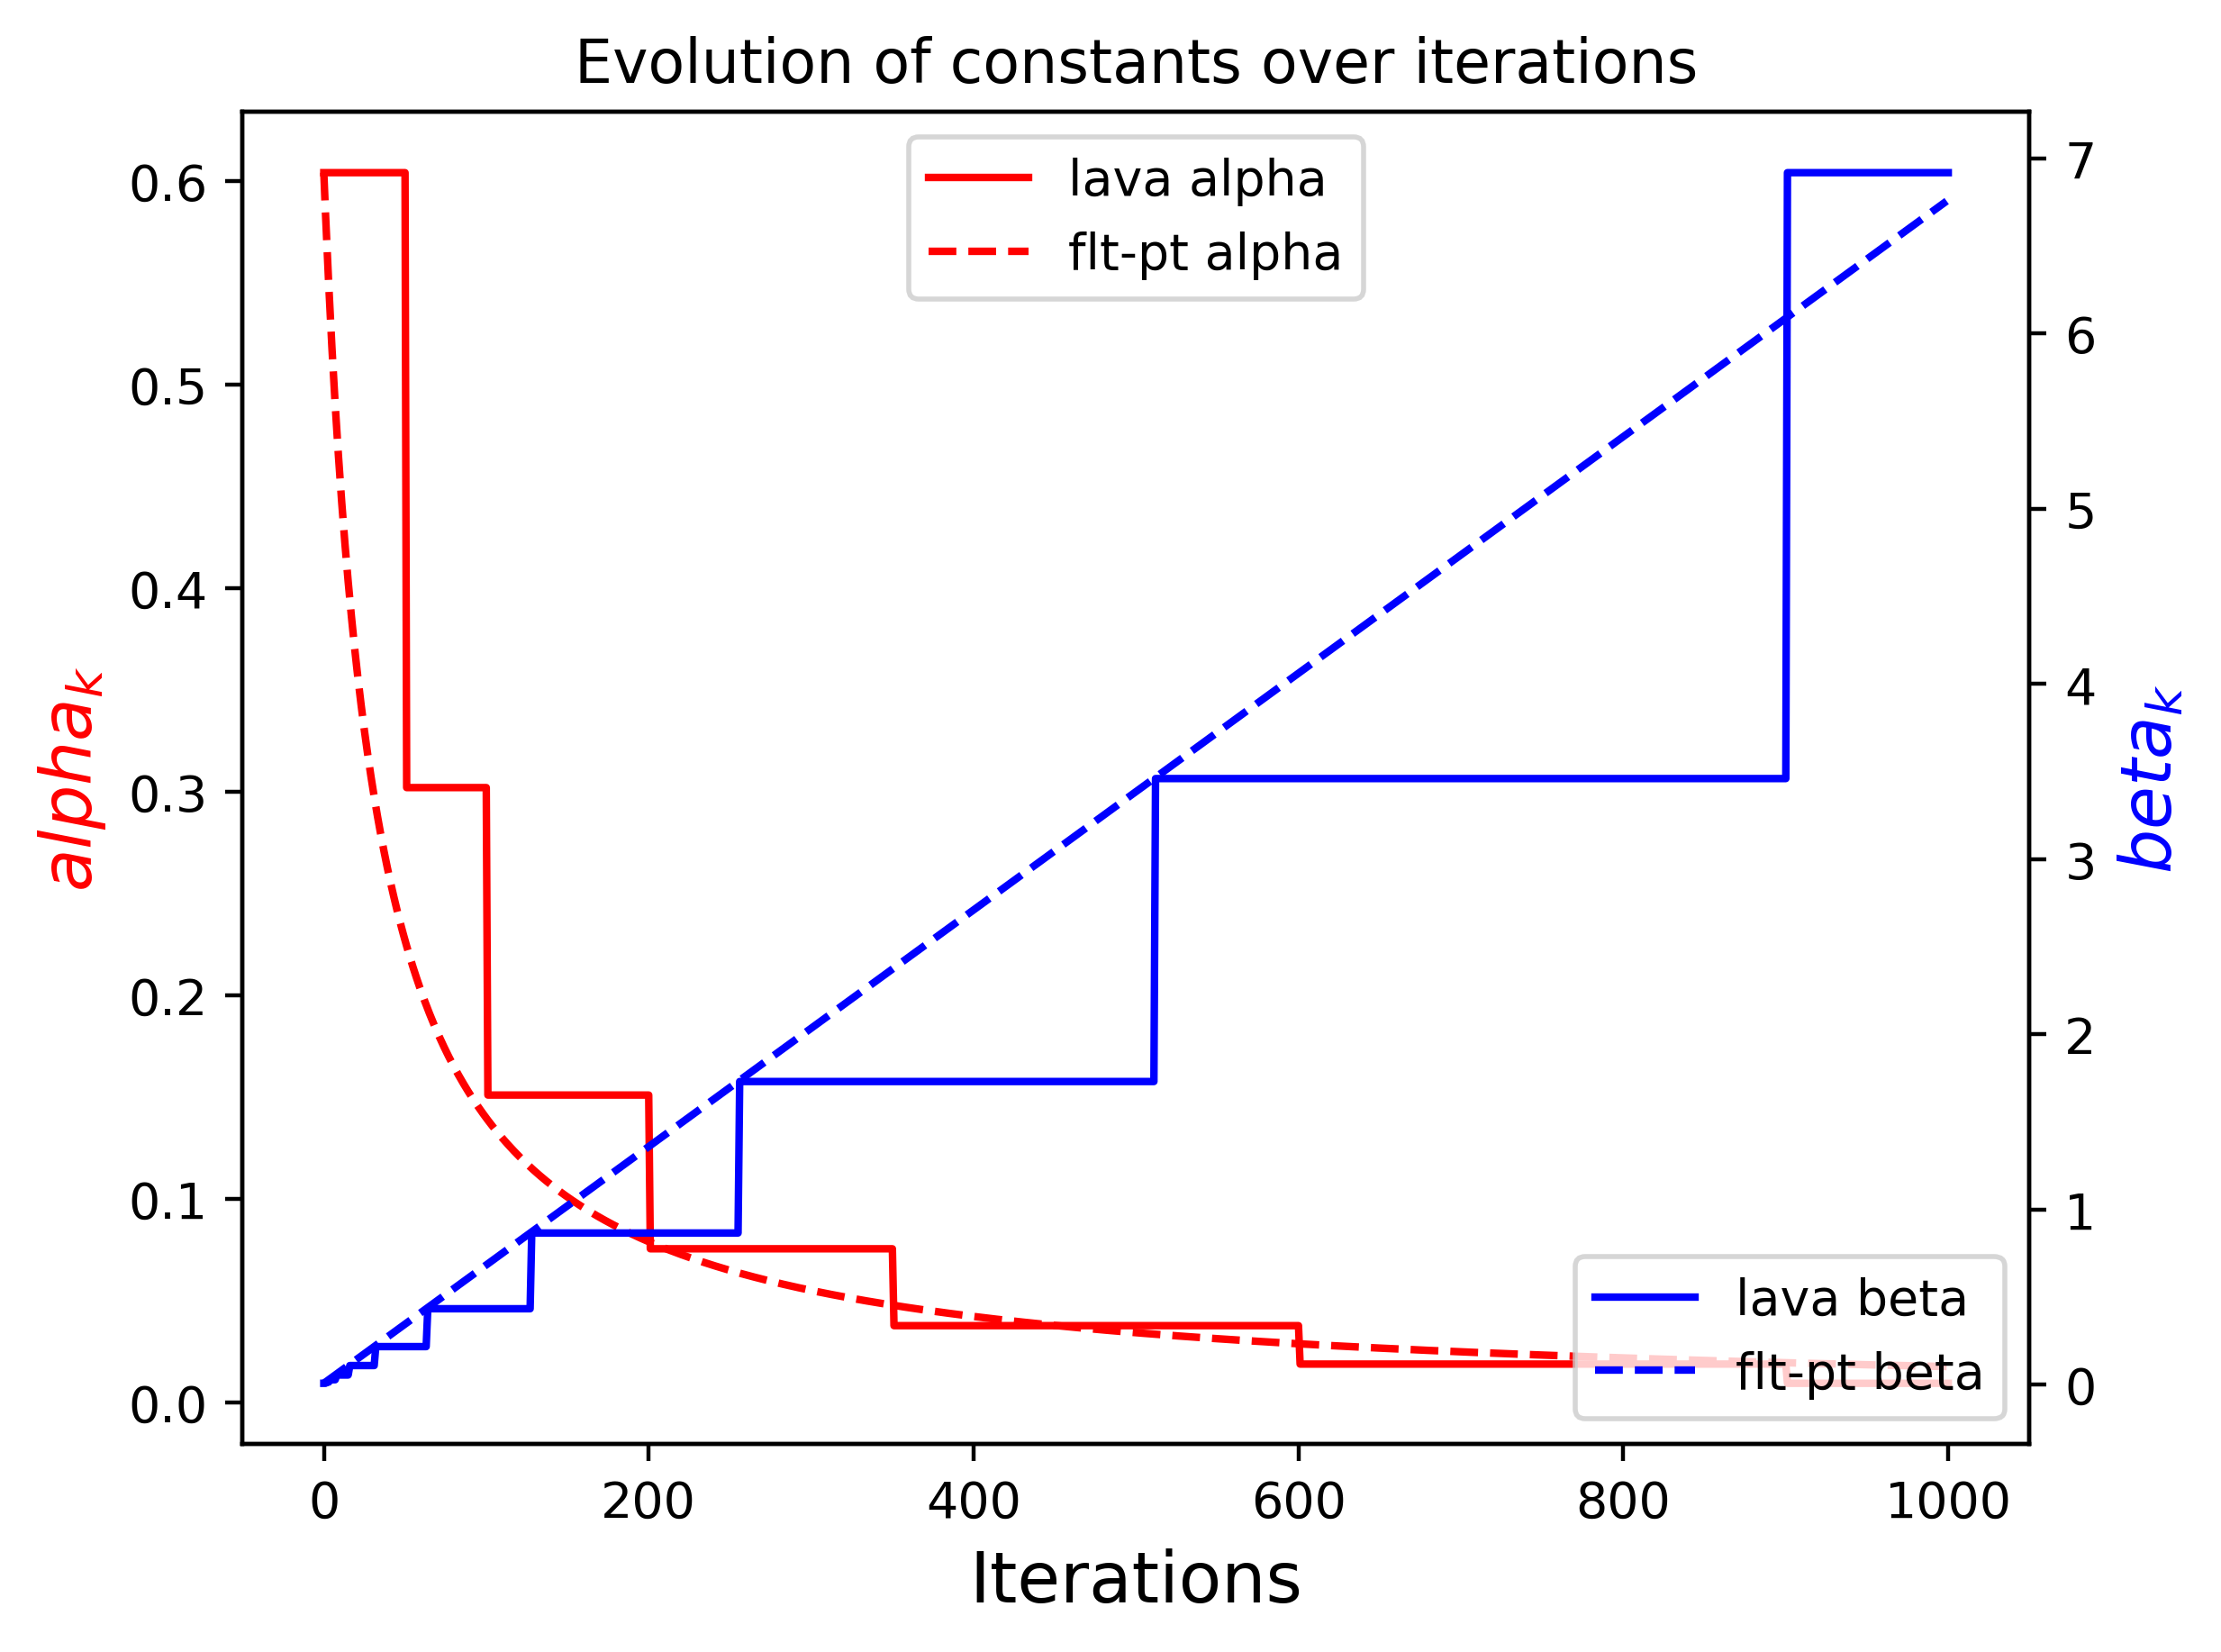

In [4]:
# Actual values of alpha and beta required over various iterations
alpha_l, beta_l  = [], []
for i in range(1000):
    alpha_l.append(alpha_pipg(i))
    beta_l.append(beta_pipg(i))

# Values of alpha and beta being used on hardware
alpha_decay_indices = [50, 100, 200, 350, 600, 900]
beta_growth_indices = [1, 3, 7, 15, 31, 63, 127, 255, 511, 900]
alpha_lava_l , beta_lava_l = [], []
alpha_lava, beta_lava = alpha_pipg(0), beta_pipg(0)
alpha_lava_l.append(alpha_lava)
beta_lava_l.append(beta_lava)
for i in range(1000):
    if (i in alpha_decay_indices):
        alpha_lava/=2
    if (i in beta_growth_indices):
        beta_lava*=2  
    alpha_lava_l.append(alpha_lava)
    beta_lava_l.append(beta_lava)

# Comparision of theoretical values vs practical values
fig,ax = plt.subplots(dpi=400)
plt.title("Evolution of constants over iterations")
ax.plot(alpha_lava_l, color="red", label='lava alpha')
ax.plot(alpha_l,'--', color="red", label='flt-pt alpha')
ax.set_xlabel("Iterations",fontsize=14)
ax.set_ylabel("$ alpha_k $",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(beta_lava_l,color="blue", label='lava beta')
ax2.plot(beta_l,'--', color="blue", label='flt-pt beta')
ax2.set_ylabel("$ beta_k $",color="blue",fontsize=14)
ax.legend(loc='upper center')
ax2.legend(loc='lower right')
plt.show()

### PIPG-based QP solver in Lava: Eventified floating-point Operation

We now run an eventified version of the QP solver with full floating point precision. The underlying algorithm is PIPGeq. To this end, we use two custom microcoded neuron models to enable the solver on Loihi 2, namely, `ProjectedGradient` neurons and `ProportionalIntegral` neurons. The processes with their behavior models are illustrated below. 

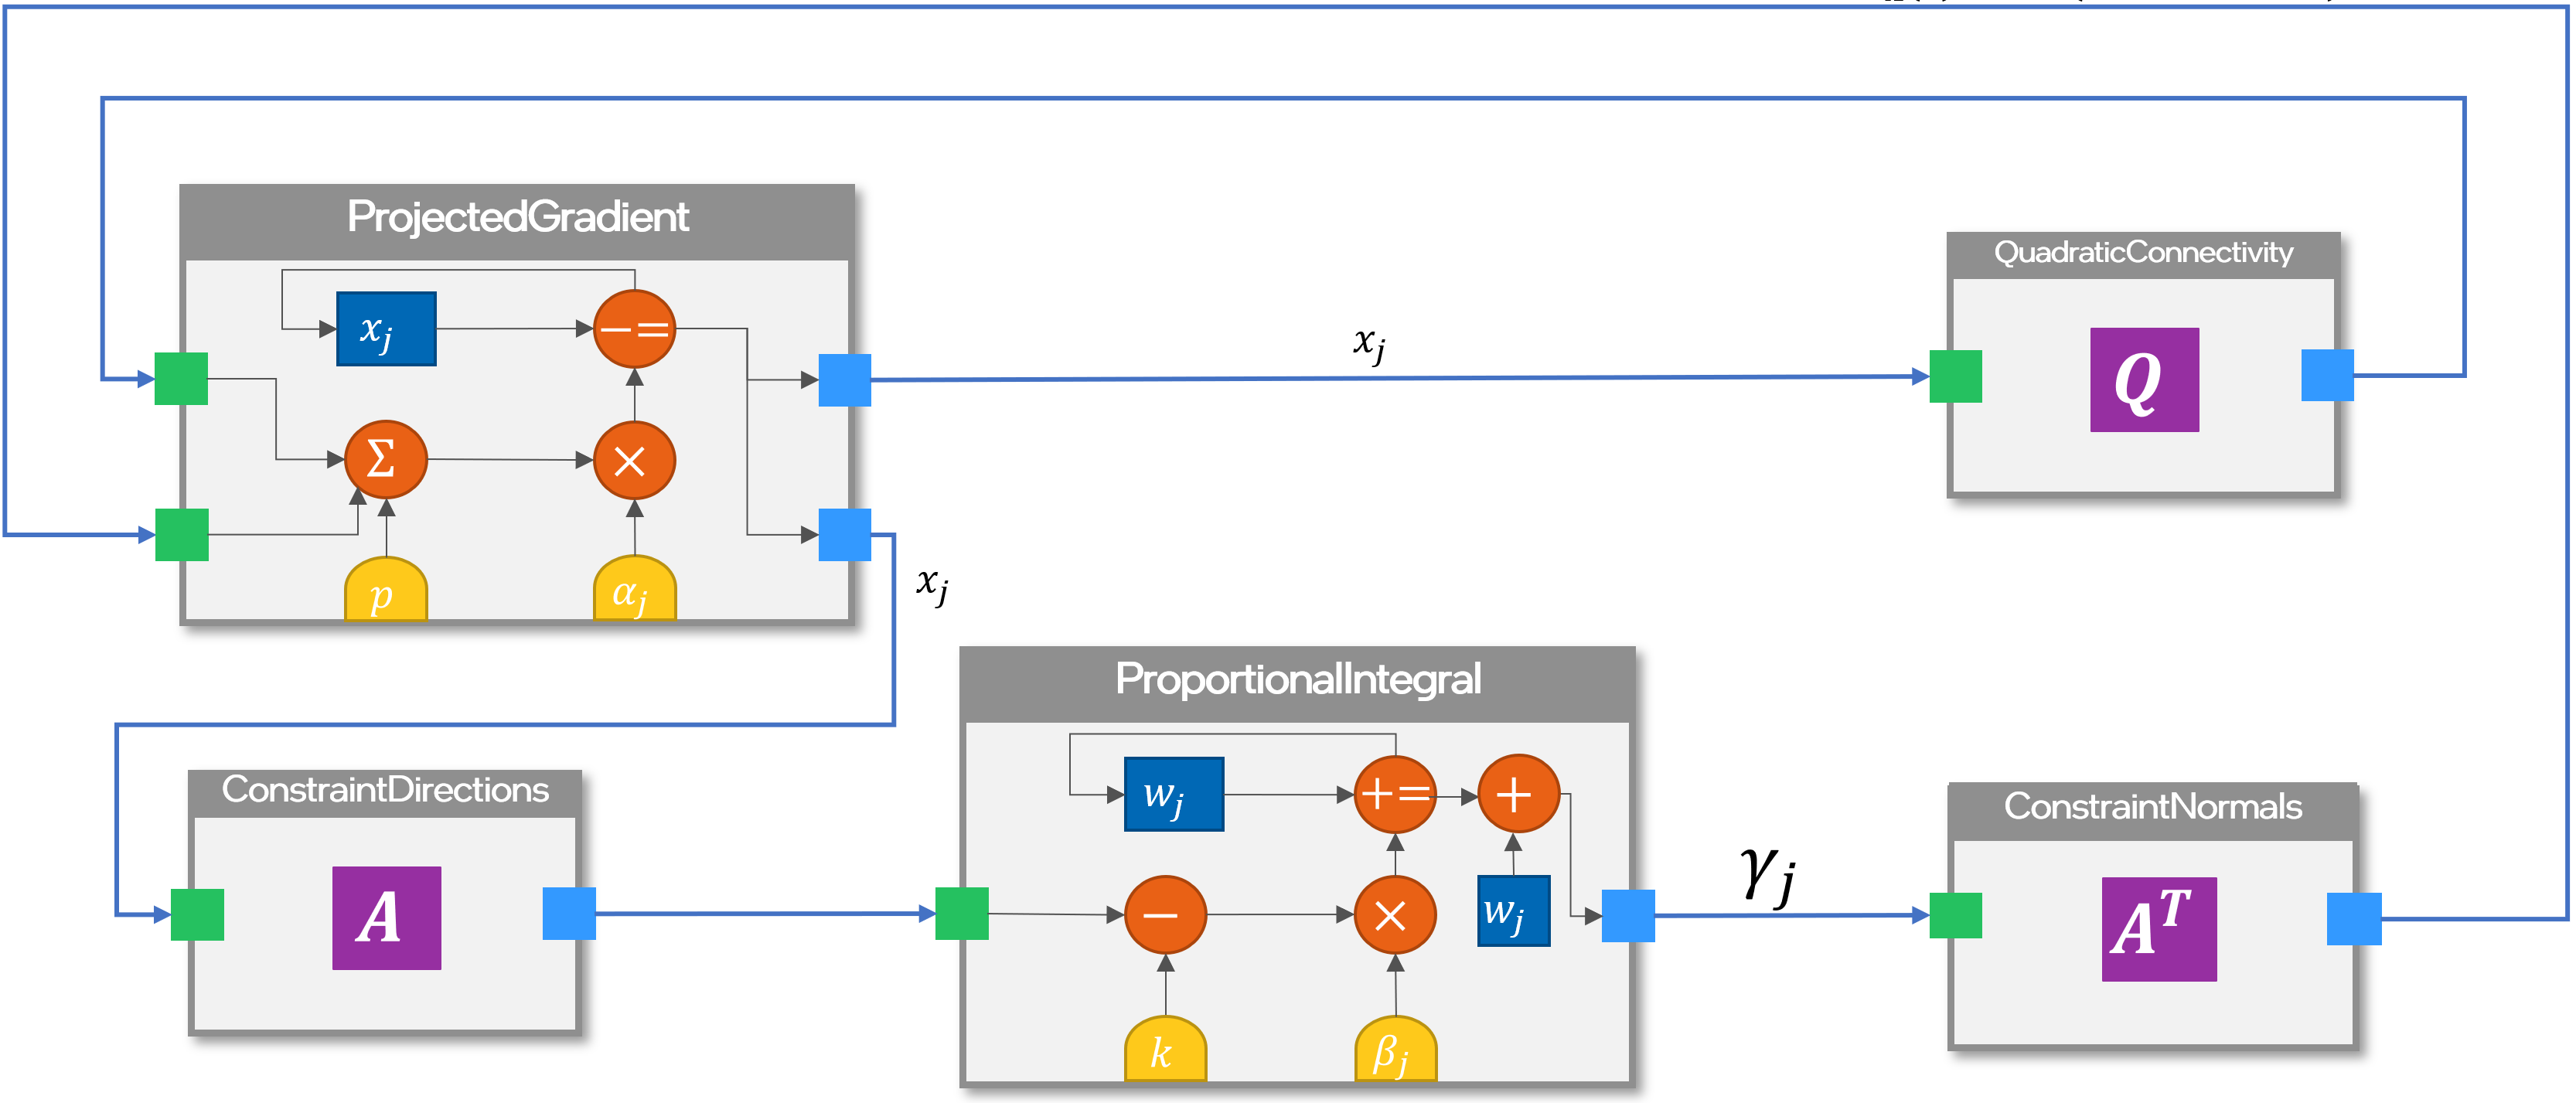

Note that the matrices are represented as Connection processes in the process diagram. In Lava these connection process are implemented by using the in-built `Dense` or `Sparse` processes and their corresponding models. The Lava solver uses 2 timesteps to carry out 1 timestep in the original PIPGeq algorithm. This is because of buffering of spikes in the connection process. The `ProjectedGradient` neurons operate in the even time-step and the `ProportionalIntegral` neurons operate in the odd-timestep. The decay and growth indices are therefore scaled accordingly to comply with this new notion of 1 PIPG time-step. 

In [5]:
alpha_decay_indices = (
    np.array([50, 100, 200, 350, 550, 800, 1100, 1450, 1850, 2300])*2
)
beta_growth_indices = (
    np.array([1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095,])*2 + 1
)

We now initialize the solver with the appropriate hyperparamters. The processes are availabe in the `lava-optimization` library. We select floating-point backends by specifying the `backend` as `CPU`.

In [6]:
from lava.lib.optimization.solvers.generic.solver import OptimizationSolver, SolverConfig

solver = OptimizationSolver(problem=problem)
config = SolverConfig(
            timeout=1000*2,
            backend="CPU",
            hyperparameters={"neuron_model": "qp-lp_pipg",
                             "alpha":alpha_pipg(0),
                             "beta": beta_pipg(0),
                             "lr_change_type": "indices",
                             "alpha_decay_indices":alpha_decay_indices ,
                             "beta_growth_indices":beta_growth_indices ,
                             },
        )
report = solver.solve(config=config)
solution = problem.postconditioner@report.best_state
print("The constraint violation is {}".format(np.linalg.norm(A@solution-k)))

The constraint violation is 0.018895569819761083


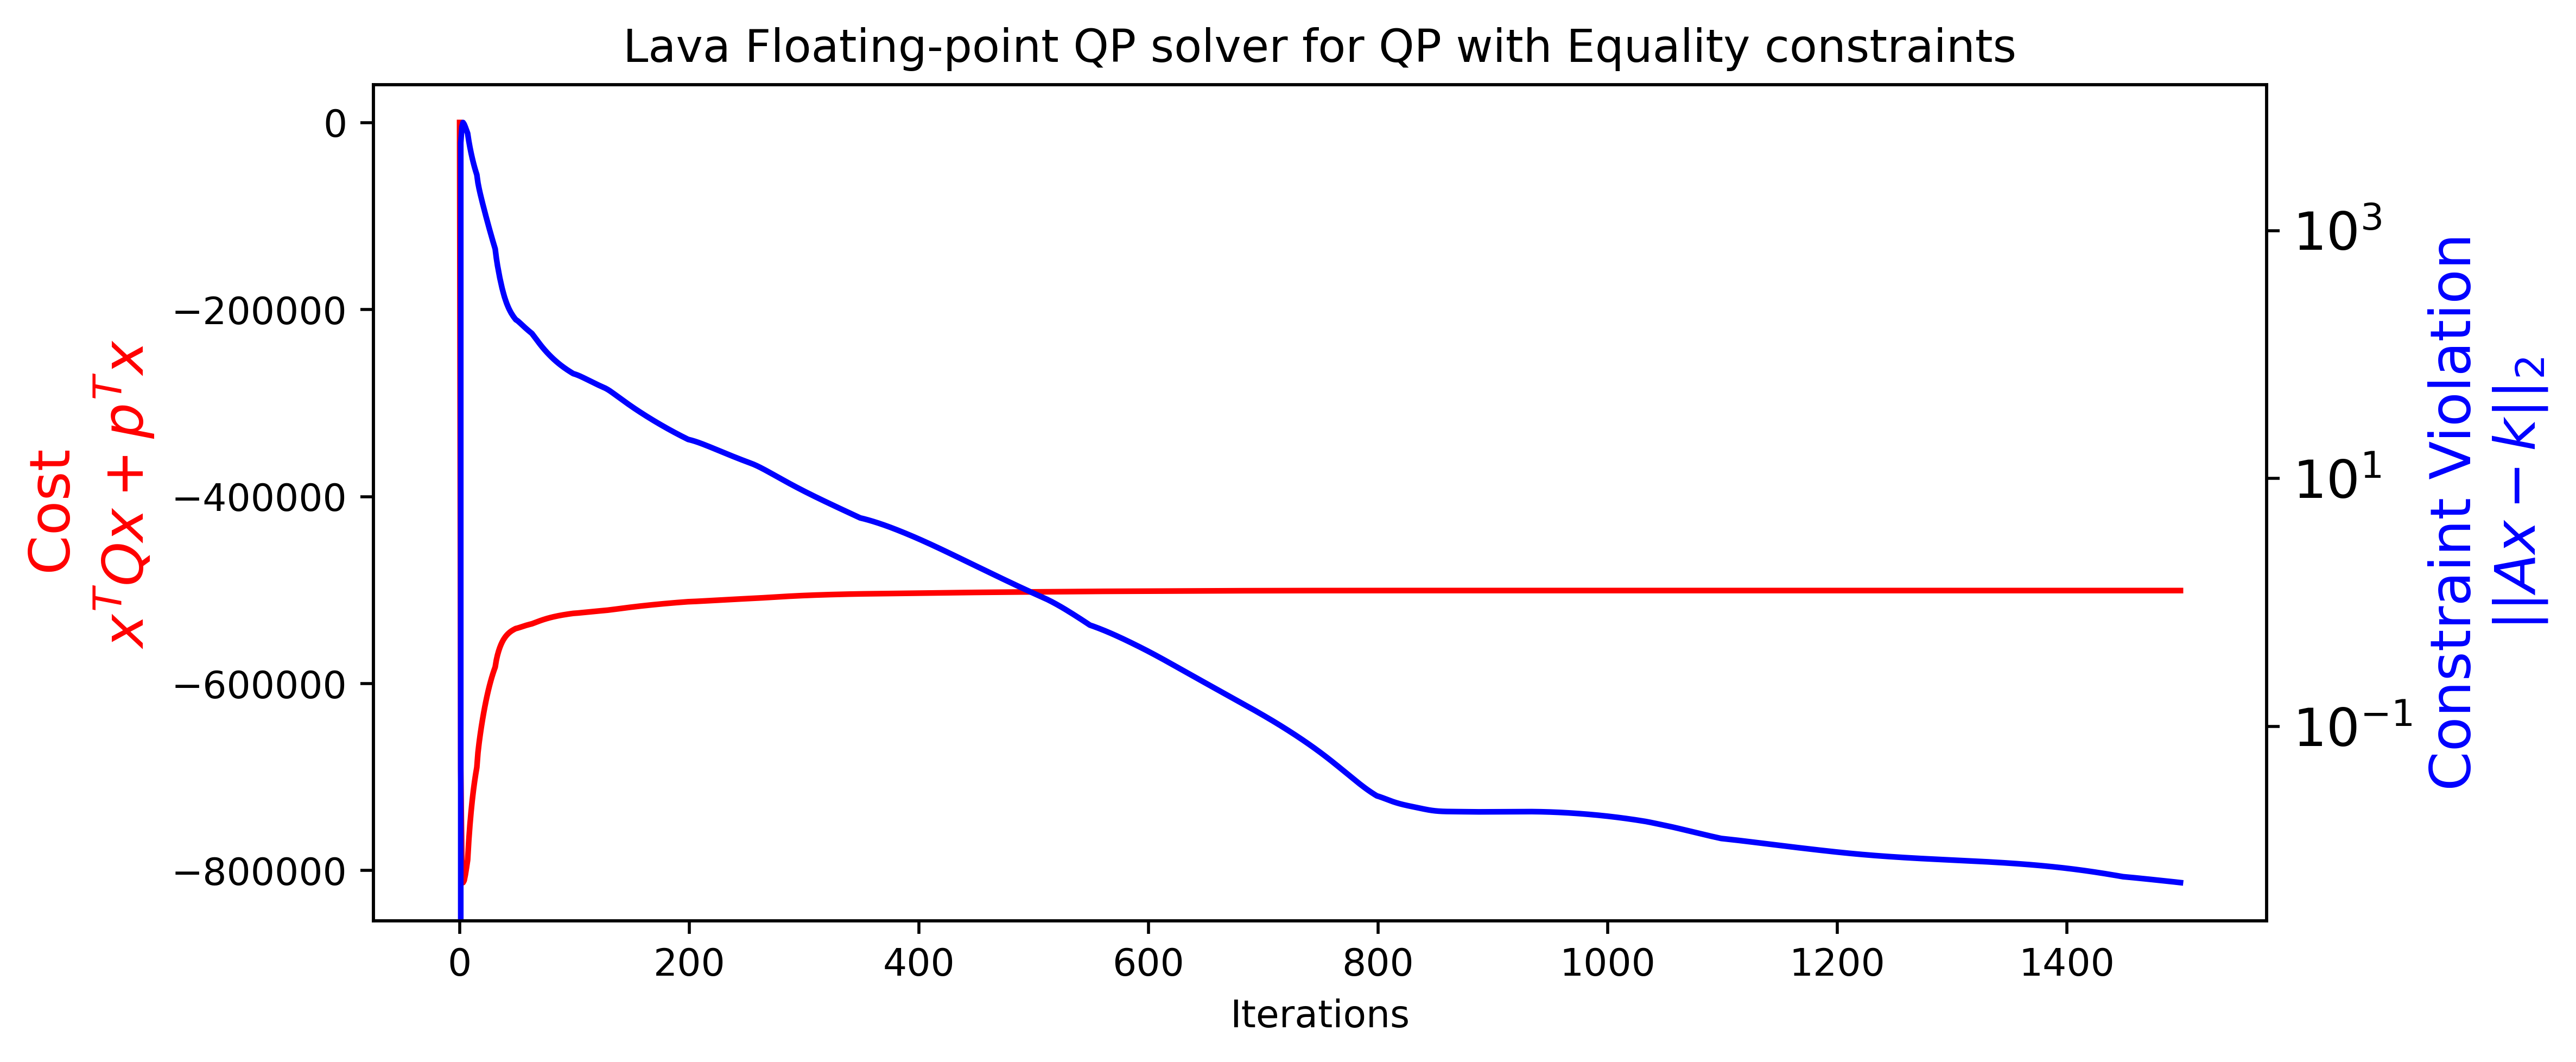

We see from the plots above that the eventified Lava floating-point solver converges to a solution and the constraints are well satisfied. Thus the QP solver with the floating point backend in Lava is functional.

NOTE: state probes to track the solution state over different iterations are not yet functional for continuous optimization problems. This is will addressesed in a future update. 
The plots are based on data collected at every time-step during the run. 

## Quadratic Programming on Loihi 2

We now move to running the QP solver on Loihi 2 using Lava. We use the same process as shown in the CPU-based solver. The backend specification in the `SolverConfig` chooses the model that must be used to run on Loihi 2. Note that this section of the tutorial can only be run by users part of the Intel Neuromorphic Research Community (INRC) since it requires access to hardware. 

We specify environmet variables that enable running the workload on the hardware.

In [7]:
from lava.utils.system import Loihi2
import os

Loihi2.preferred_partition = "oheogulch"
loihi2_is_available = Loihi2.is_loihi2_available

if loihi2_is_available:
    # Enable SLURM, the workload manager used to distribute Loihi2 resources to users
    os.environ['SLURM'] = '1'

## Solver Setup

The QP has to be mapped to Loihi 2 in accordance with the data types it uses. Therefore the floating-point problem has to be converted to a fixed-point equivalent under the limitations of the architecture. In Loihi 2, spikes are represented as 24-bit integers. The weights are represented with 8 bits with 1 bit used for the sign if the weights are signed. Additionaly one can specify an exponent for a connection process. The exponent can be a number that can be represented with 6 bits including sign. Further the state variables in the QP solver use 24 bits for their representation. 

The `alpha_decay_indices` and `beta_growth_indices` explained in the CPU-backend section are computed on the fly in the QP solver during execution in the solver uC engine. As a result, this requires specification of addition parameters `growth_factor`, `growth_index`, `decay_factor`, `decay_index` and `decay_interval`. The timestep at which halving/doubling happens is given by the `decay_index`/`growth_index` which are defined as `decay_index = decay_index + decay_interval * decay_factor` where `decay_factor += 1` after every halving and `growth_index = growth_index + 2 * growth_factor` where  `growth_factor *= 2` after every doubling. Please refer to the documentation of the neuron models for more information.    

The Lava processes for solving the QP remain the same as for the floating point solver. However, a few additional parameters specific to the hardware, e.g. exponents, have to be specified. We use settings that are known to work with the ANYmal problem

In [8]:
if loihi2_is_available:
    timeout_steps = 300*2
    config = SolverConfig(
                timeout=timeout_steps,
                backend="Loihi2",
                hyperparameters={"neuron_model": "qp-lp_pipg",
                                "alpha_mantissa":160, 
                                "alpha_exponent":-8,
                                "beta_mantissa":7, 
                                "beta_exponent":-10,
                                "decay_schedule_parameters":(100,100,0),
                                "growth_schedule_parameters":(3,2),
                                },
            )
    report = solver.solve(config=config)
    solution = report.best_state

Per core distribution:
----------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Cores |
|--------------------------------------------------------------|
|     264|       1|     288|     400|     144|       0|       1|
|     408|       1|     528|     754|     264|       0|       1|
|--------------------------------------------------------------|
| Total                                               |       2|
----------------------------------------------------------------


/home/amangalo/dev/src/github/dev/frameworks.ai.lava.lava-loihi/.venv/lib/python3.9/site-packages/nxcore/arch/base/nxboard.py:71: UserWarning: Partition None overridden by environment variable PARTITION=oheogulch
  warnings.warn("Partition {} overridden by environment variable PARTITION={}".format(partition,os.environ["PARTITION"]))


In [9]:
print("The constraint violation of the preconditioned problem"  
      " is {}".format(np.linalg.norm(
            problem.constraint_hyperplanes_eq@solution - problem.constraint_biases_eq)))

The constraint violation of the preconditioned problem is 48.039681825128646


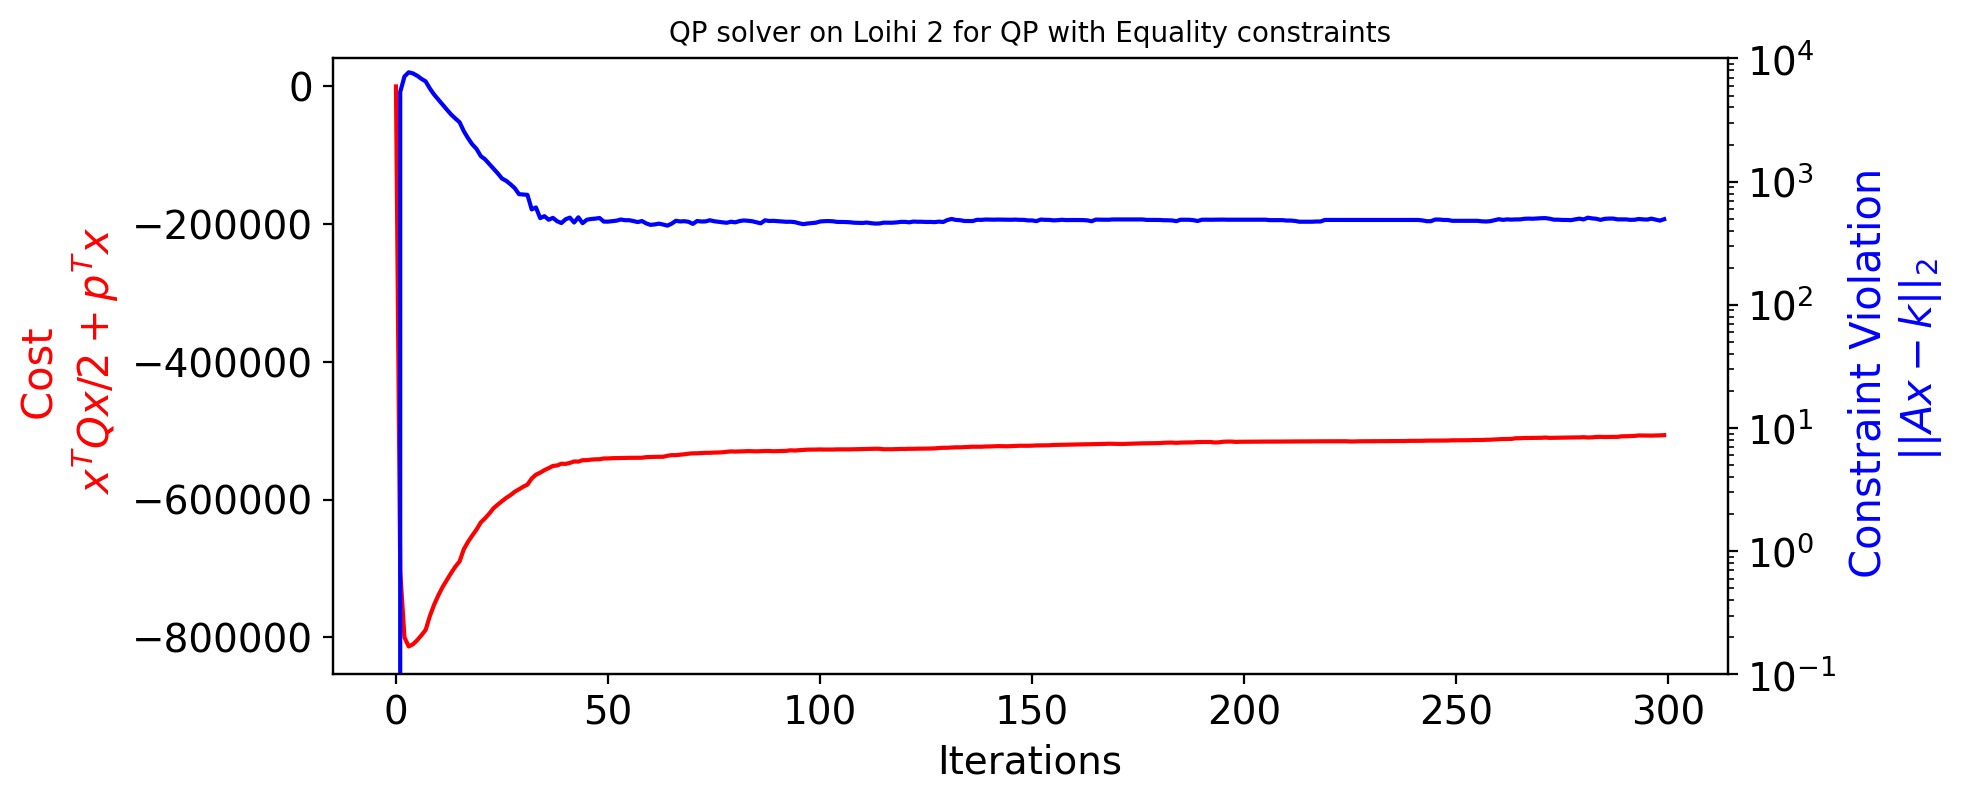

Note that the cost converges to a value that is in the range of the floating point version. From the plot of constraint violation it can be seen that the solver converges to a solution of limited accuracy because of the limitation imposed by the fixed-point representation. Future work on the Loihi 2 backend-based solver will aim to improve the solution accuracy.

Further certains parameters like mantissa and exponent of the decay/growth rates would have to be tuned according to the problem because of underflow/overflow issues asssociated with the fixed-point arithmetic for Loihi 2.

NOTE: state probes to track the solution state over different iterations are not yet functional for continuous optimization problems. This is will addressesed in a future update. 
The plots are based on data collected at every time-step during the run. 

## Profiling the QP solver

In this section we make use of the profiling tool in Lava to meaure activity and run-time of the QP solver. We setup our Processes and enable the profiler tool before running the process models. We do so by setting the `probe_time` flag to `True`.

In [10]:
if loihi2_is_available:
    # Running QP Solver on Loihi 2 backend
    config = SolverConfig(
                timeout=300*2,
                backend="Loihi2",
                hyperparameters={"neuron_model": "qp-lp_pipg",
                                "alpha_mantissa":160, 
                                "alpha_exponent":-8,
                                "beta_mantissa":7, 
                                "beta_exponent":-10,
                                "decay_schedule_parameters":(100,100,0),
                                "growth_schedule_parameters":(3,2),
                                },
                probe_time=True,
            )
    report = solver.solve(config=config)
    solution = report.best_state
    qp_profiling = report.profiler
    print("The constraint violation of the preconditioned problem"  
        " is {}".format(np.linalg.norm(
            problem.constraint_hyperplanes_eq@solution - problem.constraint_biases_eq)))


Per core distribution:
----------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Cores |
|--------------------------------------------------------------|
|     264|       1|     288|     400|     144|       0|       1|
|     408|       1|     528|     754|     264|       0|       1|
|--------------------------------------------------------------|
| Total                                               |       2|
----------------------------------------------------------------


/home/amangalo/dev/src/github/dev/frameworks.ai.lava.lava-loihi/.venv/lib/python3.9/site-packages/nxcore/arch/base/nxboard.py:71: UserWarning: Partition None overridden by environment variable PARTITION=oheogulch
  warnings.warn("Partition {} overridden by environment variable PARTITION={}".format(partition,os.environ["PARTITION"]))


The constraint violation of the preconditioned problem is 48.039681825128646


We access variables from the profiler to get measurements of execution time, spiking time, management time all for every timestep in the run. 
Note that the exeuction time can be varied by specifying an upper on the number of neurons allowed per core. This can be done by modifying the `LOIHI.db` file  

In [11]:
if loihi2_is_available:
      ## Execution time statistics 
      execution_time = np.mean(qp_profiling.execution_time)
      spiking_time = np.mean(qp_profiling.spiking_time)
      management_time = np.mean(qp_profiling.management_time)
      host_time = np.mean(qp_profiling.host_time)
      learning_time = np.mean(qp_profiling.learning_time)
      pre_lrn_mgmt_time = np.mean(qp_profiling.pre_lrn_mgtm_time)
      print(f'Mean execution time per timestep: {execution_time} s')
      print(f'Mean spiking time per timestep: {spiking_time} s')
      print(f'Mean management time per timestep: {management_time} s')
      print(f'Mean host time per timestep: {host_time} s')
      print(f'Mean learning time per timestep: {learning_time} s')
      print(f'Mean pre-learning managment time per timestep: {pre_lrn_mgmt_time} s')
      print(f"Total execution time on neuron cores :" 
            f"{np.sum(qp_profiling.execution_time)} s")

Mean execution time per timestep: 8.136666666666666e-06 s
Mean spiking time per timestep: 8.13332041139239e-06 s
Mean management time per timestep: 3.346255274276094e-09 s
Mean host time per timestep: 0.0 s
Mean learning time per timestep: 0.0 s
Mean pre-learning managment time per timestep: 0.0 s
Total execution time on neuron cores :0.004882 s


The solver converges to an approximate solution for a 264-D QP in ~3.7 ms. The fine-grained parallelism in Loihi allows to almost preserve the solution time even for larger sized problems. We eventually envision the use of this solver as a part of a larger model predictive controller that can be used to control robotic systems and comfortably scale to systems with very high degrees of freedom with a low energy budget.  

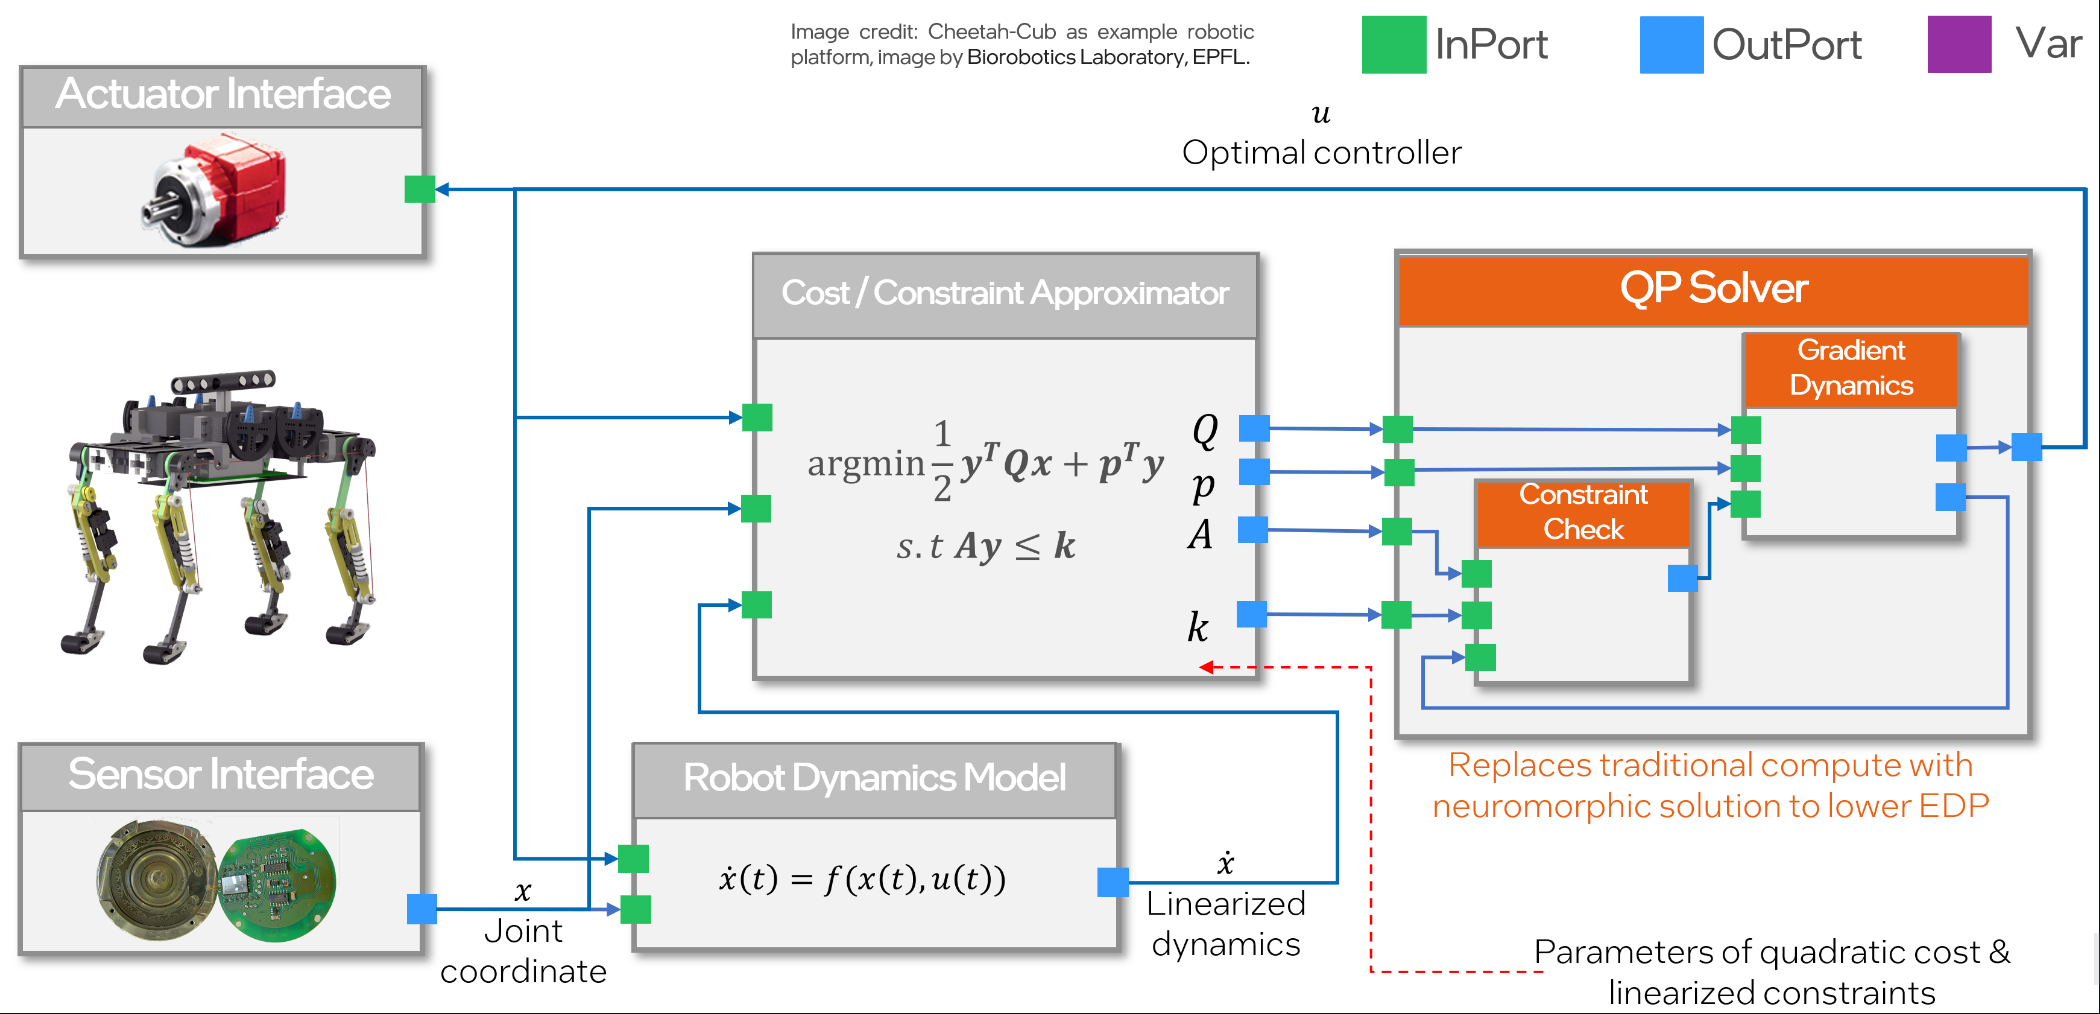

### How to learn more?

Watch this [space](https://github.com/lava-nc/lava-optimization) to learn about upcoming developments to the QP solver and the optimization toolbox in Lava in general. 

If you want to find out more about the implementation of the QP solver, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava-optimization/tree/main/src/lava/lib/optimization/solvers/qp
"QP source code").
To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").

## References


<br> [1] Yu, Yue, Purnanand Elango, and Behçet Açıkmeşe. "Proportional-integral projected gradient method for model predictive control." IEEE Control Systems Letters 5.6 (2020): 2174-2179.Available: (https://ieeexplore.ieee.org/document/9295329)
<br> [2] OCS2: An open source library for optimal control of switched systems,” [Online]. Available: https://github.com/leggedrobotics/ocs2